In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
# Download Biogeochemical and physical data using OpenDAP, require credential setup
bgc = xr.open_dataset('https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_bgc_my_0.25_P1M-m')
#phy = xr.open_dataset('https://my.cmems-du.eu/thredds/dodsC/cmems_mod_glo_phy_my_0.083_P1D-m')

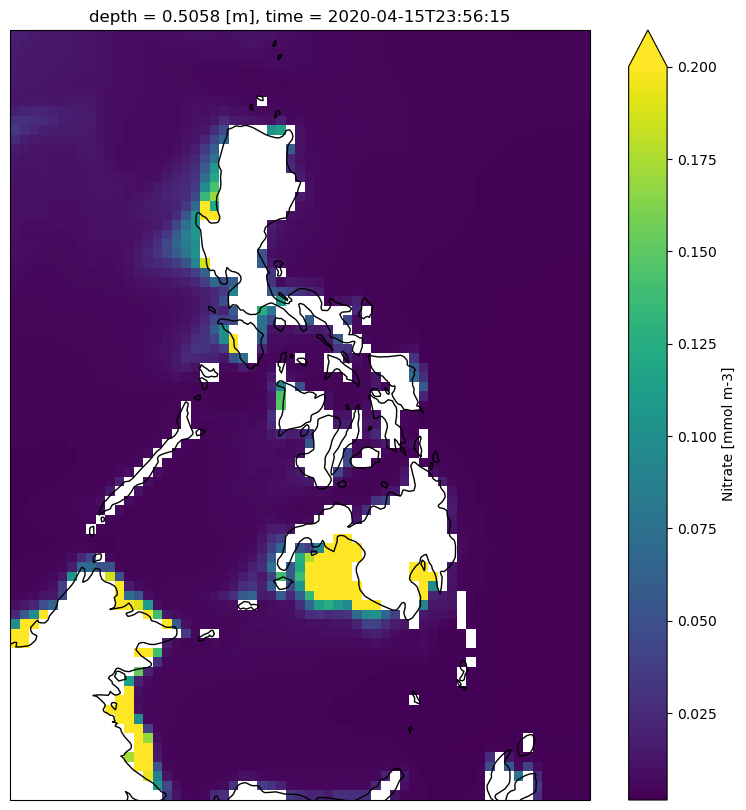

In [4]:
# Quick check of the data
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=ccrs.PlateCarree()))
bgc.isel(depth=0).sel(time=pd.to_datetime('5-1-2020'),method='nearest').sel(longitude=slice(115,130),latitude=slice(1,21)).no3.plot(cmap='viridis',vmax=0.2,subplot_kws=dict(projection=ccrs.PlateCarree()),transform=ccrs.PlateCarree())
ax.coastlines()

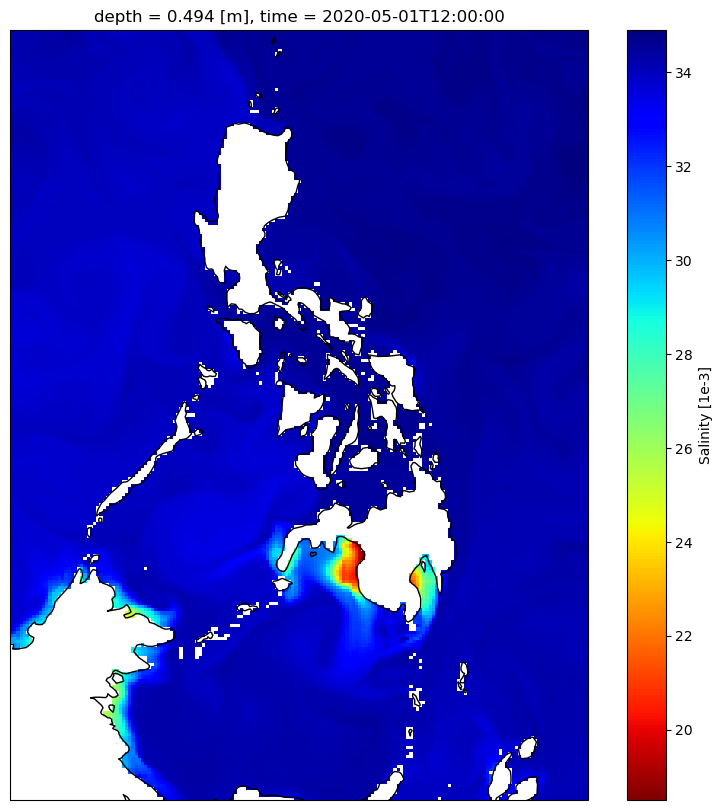

In [33]:
# Quick check
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=ccrs.PlateCarree()))
phy.isel(depth=0).sel(time=pd.to_datetime('5-1-2020'),method='nearest').sel(longitude=slice(115,130),latitude=slice(1,21)).so.plot(cmap='jet_r',subplot_kws=dict(projection=ccrs.PlateCarree()),transform=ccrs.PlateCarree())
ax.coastlines()

In [34]:
# Load fish data
fish = pd.read_csv('transformed_data_fam_chao.csv')
date = pd.to_datetime(fish.date_collected)
fish['Date']=pd.to_datetime(fish.date_collected)
#fish.iloc[:,0]
np.shape(fish)

(48, 63)

In [103]:
fish1 = fish[fish.Date <= pd.to_datetime('31-12-2020')].reset_index(drop=True)
fish2 = fish[fish.Date >= pd.to_datetime('31-12-2020')].reset_index(drop=True)

/tmp/ipykernel_1312/2761231721.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  fish1 = fish[fish.Date <= pd.to_datetime('31-12-2020')].reset_index(drop=True)
/tmp/ipykernel_1312/2761231721.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  fish2 = fish[fish.Date >= pd.to_datetime('31-12-2020')].reset_index(drop=True)


In [42]:
test = fish
ind = test[test['Date'].dt.year == 2022].index
test.iloc[ind,1] = pd.to_datetime(test.iloc[ind,1]) -  pd.DateOffset(years=2)

In [35]:
# Function to mine data
def bgc_mining(df):
    for index, row in df.iterrows():
        # Get lon lat index of nearest pixel to target coordinate
        lon_idx = abs(bgc.longitude - row['longitude']).argmin().values
        lat_idx = abs(bgc.latitude - row['latitude']).argmin().values
        # Get 3x3 grid surround target coordianate, then get rolling n-day 
        mean = bgc.sel(time=row['Date'],method='nearest').isel(depth=0, latitude=slice(lat_idx-1,lat_idx+2),longitude=slice(lon_idx-1,lon_idx+2)).mean(skipna=True)
        # Update to output table
        for i in var_list:
            df.at[index,i] = mean[i].values
    return df

def parallelize(func, df):
    num_cores = multiprocessing.cpu_count()-1  # leave one free to not freeze machine
    df_split = np.array_split(df, num_cores) # split dataframe into chunks
    pool = multiprocessing.Pool(num_cores) # number of pool
    df = pd.concat(pool.map(func, df_split)) # concatenate result
    pool.close()
    pool.join()
    return df

In [43]:
var_list = list(bgc.variables)[4:]
for i in var_list:
    test[i] = np.nan
temp = parallelize(bgc_mining,test)

In [44]:
# def phy_mining(df):
#     for index, row in df.iterrows():
#         myval = phy.isel(depth=0).sel(longitude=row['longitude'],latitude=row['latitude'],time=row['Date'],method='nearest')
#         # Update to output table
#         for i in var_list:
#             df.at[index,i] = myval[i].values
#     return df

# Function to mine data
def phy_mining(df):
    for index, row in df.iterrows():
        # Get lon lat index of nearest pixel to target coordinate
        lon_idx = abs(phy.longitude - row['longitude']).argmin().values
        lat_idx = abs(phy.latitude - row['latitude']).argmin().values
        # Get 3x3 grid surround target coordianate, then get rolling n-day 
        mean = phy.sel(time=row['Date'],method='nearest').isel(depth=0, latitude=slice(lat_idx-1,lat_idx+2),longitude=slice(lon_idx-1,lon_idx+2)).mean(skipna=True)
        # Update to output table
        for i in var_list:
            df.at[index,i] = mean[i].values
    return df

In [45]:
var_list = list(phy.variables)[4:]
for i in var_list:
    temp[i] = np.nan
final1 = parallelize(phy_mining,temp)

In [3]:
final = pd.read_csv('final_data.csv')
final

,station_code,date_collected,latitude,longitude,depth_m,s_chao1,Antennariidae,Apogonidae,Blenniidae,Gobiesocidae,...,zos,bottomT,sithick,siconc,usi,vsi,thetao,so,uo,vo
0,SU-19-01,2019-06-12,9.225000,123.480000,30.0000,99.750000,0,0,0,0,...,0.668966,12.644643,NaN,NaN,NaN,NaN,30.139318,34.520248,0.034588,0.010376
1,SU-19-02,2019-06-12,9.141110,123.494440,10.7000,88.368421,0,0,0,0,...,0.667643,12.349711,NaN,NaN,NaN,NaN,30.094759,34.522793,0.049135,-0.002543
2,SU-19-03,2019-06-13,9.141670,123.489440,6.0000,114.750000,0,0,0,0,...,0.670339,12.407697,NaN,NaN,NaN,NaN,30.077303,34.491257,0.105492,-0.045066
3,SU-22-04,2022-05-14,9.051177,122.989603,5.0000,175.500000,0,0,0,0,...,0.763486,15.070969,NaN,NaN,NaN,NaN,29.270237,32.681183,-0.039674,-0.054410
4,SU-22-05,2022-05-16,9.069584,123.146874,2.5000,120.333333,0,0,0,0,...,0.760696,13.247705,NaN,NaN,NaN,NaN,29.160997,32.897213,-0.054236,0.001395
5,SU-22-06,2022-05-19,9.090244,122.933662,3.5000,73.400000,0,0,0,0,...,0.765442,13.062777,NaN,NaN,NaN,NaN,29.272591,32.582703,-0.006561,-0.117954
6,SU-22-07,2022-05-23,9.044980,123.127144,9.1000,123.571429,0,0,0,0,...,0.760696,13.247705,NaN,NaN,NaN,NaN,29.160997,32.897213,-0.054236,0.001395
7,SU-22-08,2022-05-25,9.067396,123.149691,3.0000,124.625000,0,0,0,0,...,0.760696,13.247705,NaN,NaN,NaN,NaN,29.160997,32.897213,-0.054236,0.001395
8,SU-22-09,2022-06-02,10.918060,121.034170,4.6000,132.375000,0,0,0,0,...,0.816980,28.559719,NaN,NaN,NaN,NaN,28.991293,32.586647,-0.455879,-0.429565
9,SU-22-10,2022-06-03,10.907192,121.060551,0.7600,3.500000,0,0,0,0,...,0.816065,28.443586,NaN,NaN,NaN,NaN,29.011963,32.592243,-0.356253,-0.587719


In [4]:
family =final.iloc[27:,6:62]
family

,Antennariidae,Apogonidae,Blenniidae,Gobiesocidae,Gobiidae,Haemulidae,Labridae,Muraenidae,Nemipteridae,Pinguipedidae,...,Synanceiidae,Creediidae,Priacanthidae,Moringuidae,Percophidae,Mullidae,Uranoscopidae,Plotosidae,Opittognathidae,Diodontidae
27,0,7,0,0,2,0,6,1,0,11,...,0,0,0,0,0,0,0,0,0,0
28,0,41,0,0,280,0,101,16,0,6,...,0,0,0,0,0,0,0,0,0,0
29,0,46,0,0,44,1,60,6,0,4,...,0,0,0,0,0,0,0,0,0,0
30,0,5,0,0,212,0,283,6,1,11,...,0,0,0,0,0,0,0,0,0,0
31,1,7,20,3,30,0,7,18,0,3,...,1,0,0,0,0,0,0,0,0,0
32,0,16,0,0,351,0,17,6,2,2,...,0,0,0,0,0,0,0,0,0,0
33,0,14,21,0,333,0,9,9,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,14,0,0,133,0,29,7,0,4,...,0,1,1,0,0,0,0,0,0,0
35,1,7,0,1,38,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,24,10,0,23,0,18,5,0,1,...,0,0,0,1,0,0,0,0,0,0


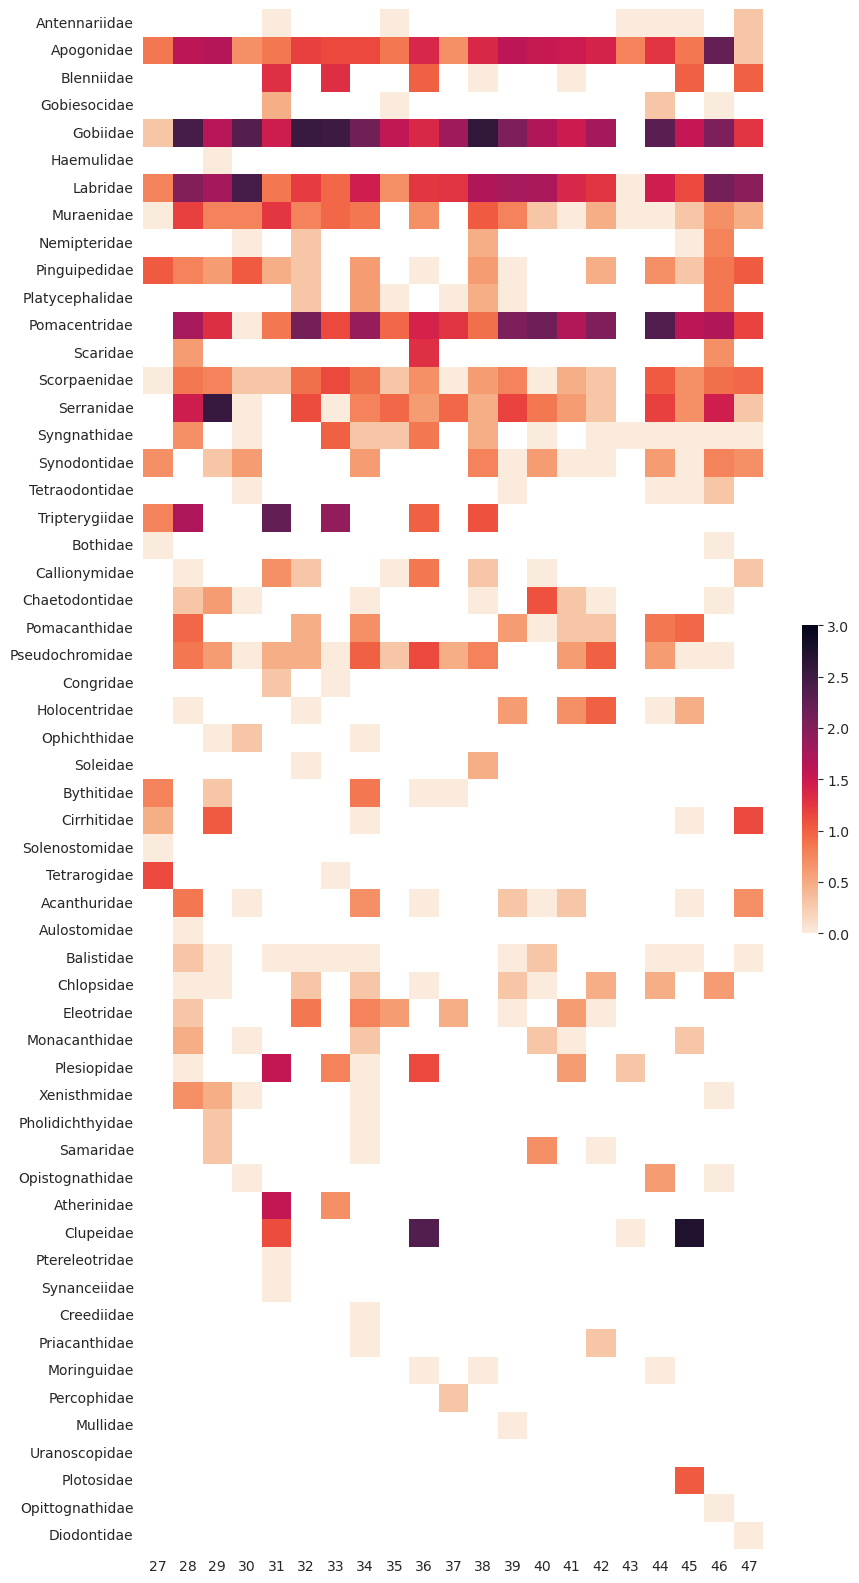

In [9]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10,20))
sns.set_style("white")
family_log= np.log10(family)
ax=sns.heatmap(family_log.transpose(),vmin=0,vmax=3,cmap='rocket_r',xticklabels=True, yticklabels=True,
              cbar_kws={'shrink': 0.2})

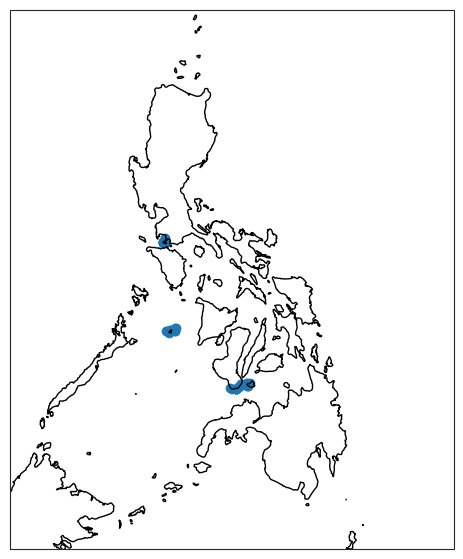

In [11]:
f, ax = plt.subplots(figsize=(7,7),subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([116, 130, 4, 21])
ax.coastlines()
ax.scatter(final.longitude,final.latitude)

In [63]:
from sklearn.model_selection import train_test_split
df = final
feature_list = ['spco2', 'chl', 'fe', 'no3',
       'nppv', 'o2', 'ph', 'phyc', 'po4', 'si', 'mlotst', 'zos', 'bottomT', 'thetao', 'so', 'uo', 'vo']
pft_list = ['s_chao1']

# df.dropna(subset=feature_list,axis=0,inplace=True)
# df.dropna(subset=pft_list,axis=0,inplace=True)
predictor = df[feature_list]
predictor_mean=np.mean(predictor,axis=0)
predictor_std=np.std(predictor,axis=0)
predictor = (predictor-predictor_mean)/predictor_std
y = df[pft_list]
trainX, testX, trainY, testY = train_test_split(predictor,y,test_size=0.4)


R squared:  -0.5431877665815878

RMSE:
33.603710139154316

Normalized RMSE:
s_chao1    0.29269
dtype: float64


/tmp/ipykernel_395/1766890676.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFreg.fit(trainX, trainY)
/home/anhph/mambaforge/envs/uncw/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/anhph/mambaforge/envs/uncw/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Text(0, 140, 'RMSE = 33.6')

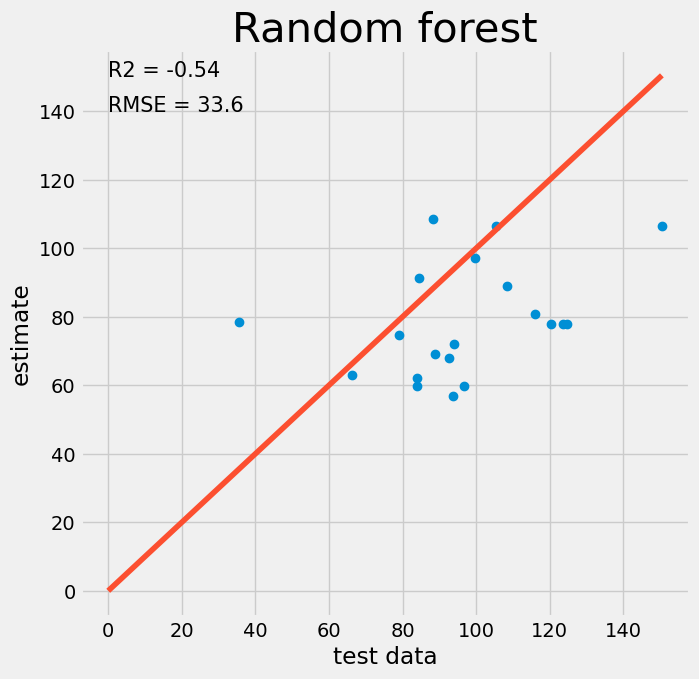

In [64]:
fig, ax = plt.subplots(figsize=(7, 7))
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor(random_state=0)
RFreg.fit(trainX, trainY)
r2 = RFreg.score(testX, testY)
print('R squared: ',r2)
est = RFreg.predict(testX)
plt.plot(testY,est,'o')
plt.plot([0,np.nanmax(testY)],[0,np.nanmax(testY)],'-')
RMSE=np.sqrt(np.mean((testY.values-est)**2))
print('\nRMSE:')
print(RMSE)
print('\nNormalized RMSE:')
print(RMSE/(np.max(testY)-np.min(testY)))
plt.xlabel('test data')
plt.ylabel('estimate')
plt.title('Random forest',fontsize=30)
#plt.legend(pft_list)
plt.text(0,150,f'R2 = {round(r2,2)}',fontsize=15)
plt.text(0,140,f'RMSE = {round(RMSE,2)}',fontsize=15)

Variable: bottomT              Importance: 0.17
Variable: uo                   Importance: 0.13
Variable: vo                   Importance: 0.11
Variable: mlotst               Importance: 0.1
Variable: thetao               Importance: 0.09
Variable: zos                  Importance: 0.08
Variable: no3                  Importance: 0.07
Variable: so                   Importance: 0.05
Variable: fe                   Importance: 0.04
Variable: po4                  Importance: 0.04
Variable: spco2                Importance: 0.03
Variable: phyc                 Importance: 0.03
Variable: o2                   Importance: 0.02
Variable: si                   Importance: 0.02
Variable: chl                  Importance: 0.01
Variable: nppv                 Importance: 0.01
Variable: ph                   Importance: 0.01


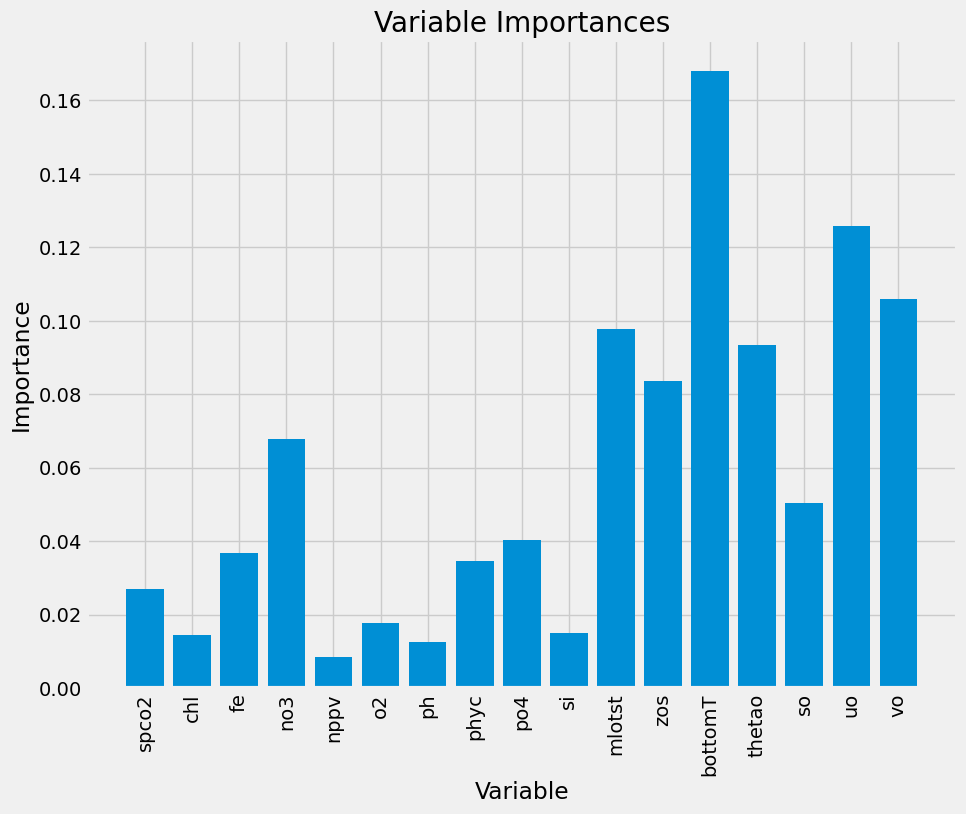

In [65]:
# Variable importances
fig, ax = plt.subplots(figsize=(10, 8))
importances = list(RFreg.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

R squared:  0.020534936634616252

RMSE:
47.75004116647249

Normalized RMSE:
s_chao1    0.387629
dtype: float64


/tmp/ipykernel_395/3666652551.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFreg.fit(trainX, trainY)
/home/anhph/mambaforge/envs/uncw/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/anhph/mambaforge/envs/uncw/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


Text(0, 80, 'RMSE = 47.75')

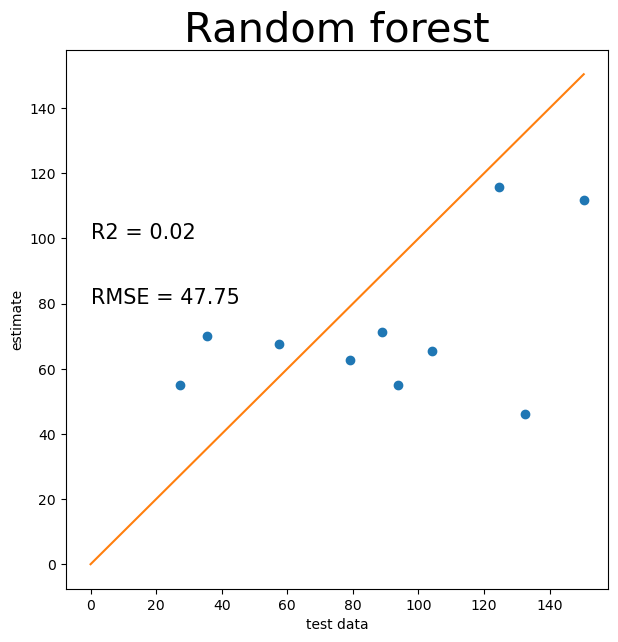

In [23]:
from sklearn.model_selection import train_test_split
df = final
feature_list = ['mlotst','zos', 'bottomT','thetao','so', 'uo', 'vo']
pft_list = ['s_chao1']

# df.dropna(subset=feature_list,axis=0,inplace=True)
# df.dropna(subset=pft_list,axis=0,inplace=True)
predictor = df[feature_list]
predictor_mean=np.mean(predictor,axis=0)
predictor_std=np.std(predictor,axis=0)
predictor = (predictor-predictor_mean)/predictor_std
y = df[pft_list]
trainX, testX, trainY, testY = train_test_split(predictor,y,test_size=0.2)

fig, ax = plt.subplots(figsize=(7, 7))
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor(random_state=0)
RFreg.fit(trainX, trainY)
r2 = RFreg.score(testX, testY)
print('R squared: ',r2)
est = RFreg.predict(testX)
plt.plot(testY,est,'o')
plt.plot([0,np.nanmax(testY)],[0,np.nanmax(testY)],'-')
RMSE=np.sqrt(np.mean((testY.values-est)**2))
print('\nRMSE:')
print(RMSE)
print('\nNormalized RMSE:')
print(RMSE/(np.max(testY)-np.min(testY)))
plt.xlabel('test data')
plt.ylabel('estimate')
plt.title('Random forest',fontsize=30)
#plt.legend(pft_list)
plt.text(0,100,f'R2 = {round(r2,2)}',fontsize=15)
plt.text(0,80,f'RMSE = {round(RMSE,2)}',fontsize=15)


In [5]:
ds = xr.open_dataset('phy.nc')
N=np.shape(ds.zos.to_numpy())
Xm = predictor_mean
Xstd = predictor_std
reg=RFreg
# # generate input data
mlo1 = np.reshape(ds.mlotst.to_numpy(),[N[0]*N[1],1]) 
thetao1 = np.reshape(ds.thetao.to_numpy(),[N[0]*N[1],1]) 
zos1 = np.reshape(ds.zos.to_numpy(),[N[0]*N[1],1]) 
bot1 = np.reshape(ds.bottomT.to_numpy(),[N[0]*N[1],1])
so1 = np.reshape(ds.so.to_numpy(),[N[0]*N[1],1]) 
uo1 = np.reshape(ds.uo.to_numpy(),[N[0]*N[1],1]) 
vo1 = np.reshape(ds.vo.to_numpy(),[N[0]*N[1],1]) 
# coordinates
x=ds.longitude.to_numpy()
y=ds.latitude.to_numpy()
xx,yy=np.meshgrid(x,y)
x1=np.reshape(xx,[N[0]*N[1],1])
y1=np.reshape(yy,[N[0]*N[1],1])
# generate X array and its normalization
X=np.array([mlo1,zos1,bot1,thetao1,so1,uo1,vo1])
# remove nan
dd=np.sum(X,axis=0)
ind=(np.isnan(dd)==False)
Xa = np.squeeze(X[:,ind]).T
Xm = np.tile(Xm.values.T,(np.shape(Xa)[0],1))
Xstd = np.tile(Xstd.values.T,(np.shape(Xa)[0],1))
testX=(Xa-Xm)/Xstd
# project
est = reg.predict(testX)
est = np.where(est<0,0,est)
# remap 
est1=np.nan*np.ones((N[0]*N[1],1))
#est2=np.nan*np.ones((N[1]*N[2],1))
est1[ind]=np.squeeze(est)
#est2[ind]=est[:,1]
tr1=np.reshape(est1,[N[0],N[1]])
#tr2=np.reshape(est2,[N[1],N[2]])


/home/anhph/mambaforge/envs/uncw/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


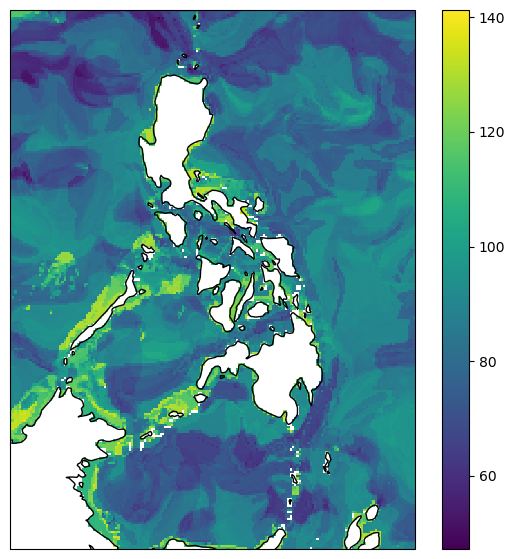

In [20]:
fig, ax = plt.subplots(figsize=(7, 7),subplot_kw=dict(projection=ccrs.PlateCarree()))
pcolormesh = ax.pcolormesh(x,y,tr1,cmap='viridis')
ax.coastlines()
cbar = plt.colorbar(pcolormesh, ax=ax)